# Comparing Imputers on the ExtraSensory data set

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [3]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from mFlow.Workflow.workflow import workflow
import mFlow.Workflow.compute_graph



## Define the workflow

This workflow uses a basic train/test experiment to compare two different imputation methods: zero imputation and mean imputation. The model used is logistic regression with a fixed regularization hyper-parameter. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, and a missing label filter that removes instances without labels. Next, the workflow performs imputation in each of two differnt ways. For each branch of the workflow, normalization is applied, followed by the the train/test experiment. Data loading and filtering is shared across the two branches of the workflow. The workflow computation graph is then created and displayed along with the results. 

In this experiment, we can see that the use of mean imputation results in more than a 10% performance improvement relative to zero imputation.

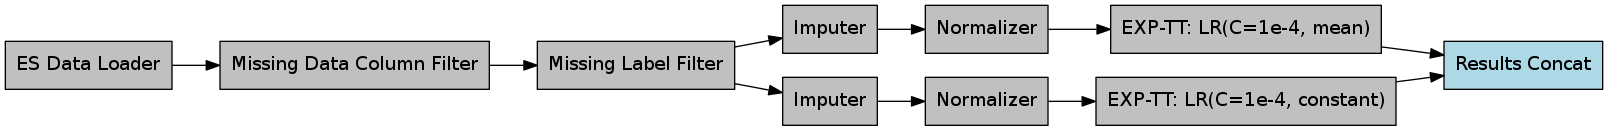

In [5]:
imp_methods = ["mean", "constant"]
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);

res=[]
for i,m in enumerate(imp_methods):
    df_imp = Imputer(df_lf, method=m)
    df_norm = Normalizer(df_imp)
    models = {"LR(C=1e-4, %s)"%m: LogisticRegression(solver="lbfgs",max_iter=100)}
    res.append(ExpTrainTest(df_norm, models, metrics=metrics));

res_cat = ResultsConcat(*res)
flow    = workflow({"results":res_cat})
 
flow.draw(); plt.show();
output=flow.run(backend="sequential", monitor=True, from_scratch=True);

In [6]:
output["results"]["report"]

,accuracy_score,f1_score,precision_score,recall_score
"LR(C=1e-4, mean)",0.861992,0.715716,0.836194,0.625583
"LR(C=1e-4, constant)",0.772334,0.544758,0.612494,0.490512
